running typecheck
Success: no issues found in 1 source file

running flake8
flake8 success


TestResults(failed=0, attempted=5)

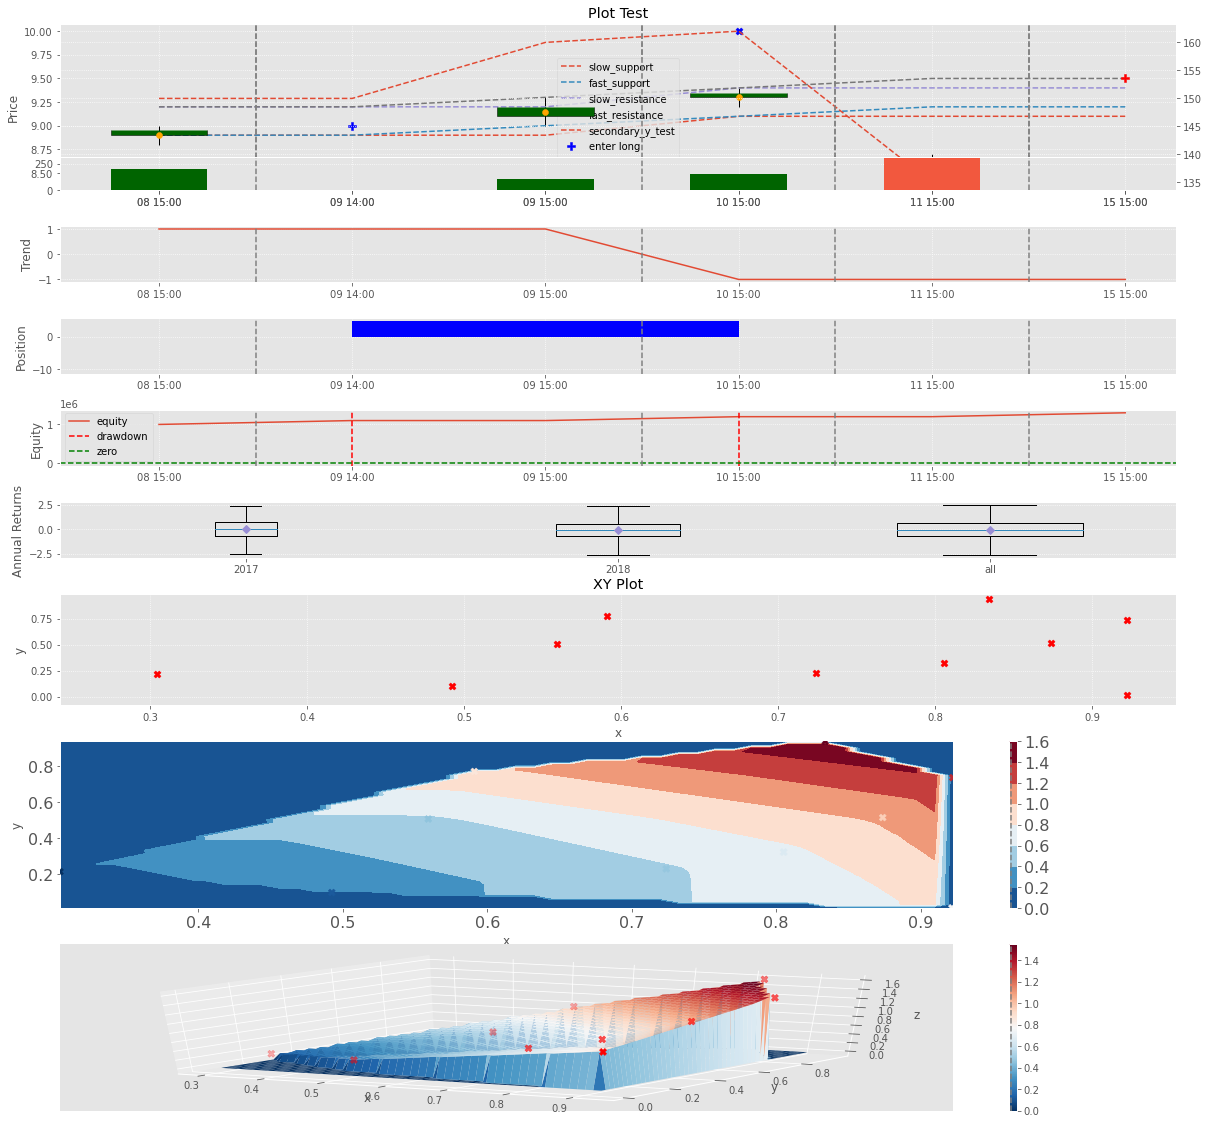

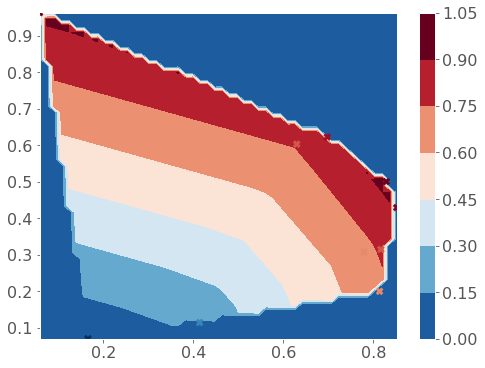

In [8]:
%%checkall
from dataclasses import dataclass
import collections
import math
from abc import abstractmethod
from functools import reduce
import pandas as pd
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import matplotlib.patches as mptch
import matplotlib.gridspec as gridspec
import matplotlib.path as path
import matplotlib.cm as cm
from matplotlib.colors import BoundaryNorm

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401  # not directly used but need to import to plot 3d 
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pyqstrat.pq_utils import set_defaults, series_to_array, strtup2date, has_display, resample_ts, resample_trade_bars
from pyqstrat.pq_types import ReasonCode, Trade
from typing import Sequence, Tuple, Mapping, Union, MutableMapping, List, Optional

set_defaults()

_VERBOSE: bool = False
    

class DateFormatter(mtick.Formatter):
    '''
    Formats timestamps on plot axes.  See matplotlib Formatter
    '''
    def __init__(self, timestamps: np.ndarray, fmt: str) -> None:
        self.timestamps = timestamps
        self.fmt = fmt

    def __call__(self, x, pos: int = 0):
        'Return the label for time x at position pos'
        ind = int(np.round(x))
        if ind >= len(self.timestamps) or ind < 0: return ''
        return mdates.num2date(self.timestamps[ind]).strftime(self.fmt)
    

class HorizontalLine:
    '''Draws a horizontal line on a subplot'''
    def __init__(self, y: float, name: str = None, line_type: str = 'dashed', color: str = None) -> None:
        self.y = y
        self.name = name
        self.line_type = line_type
        self.color = color
    

class VerticalLine:
    '''Draws a vertical line on a subplot where x axis is not a date-time axis'''
    def __init__(self, x: float, name: str = None, line_type: str = 'dashed', color: str = None) -> None:
        self.x = x
        self.name = name
        self.line_type = line_type
        self.color = color
    

class DateLine:
    '''Draw a vertical line on a plot with a datetime x-axis'''
    def __init__(self, date: np.datetime64, name: str = None, line_type: str = 'dashed', color: str = None) -> None:
        self.date = date
        self.name = name
        self.line_type = line_type
        self.color = color
        
        
class DisplayAttributes:
    pass


@dataclass
class BoxPlotAttributes(DisplayAttributes):
    '''
    Attributes:
        proportional_widths: if set to True, the width each box in the boxplot will be proportional 
            to the number of items in its corresponding array
        show_means: Whether to display a marker where the mean is for each array
        show_outliers: Whether to show markers for outliers that are outside the whiskers.  
            Box is at Q1 = 25%, Q3 = 75% quantiles, whiskers are at Q1 - 1.5 * (Q3 - Q1), Q3 + 1.5 * (Q3 - Q1)
        notched: Whether to show notches indicating the confidence interval around the median
    '''
    proportional_widths: bool = True
    show_means: bool = True
    show_all: bool = True
    show_outliers: bool = False
    notched: bool = False


@dataclass
class LinePlotAttributes(DisplayAttributes):
    line_type: Optional[str] = 'solid'
    line_width: Optional[int] = None
    color: Optional[str] = None
    marker: Optional[str] = None
    marker_size: Optional[int] = None
    marker_color: Optional[str] = None


@dataclass
class ScatterPlotAttributes(DisplayAttributes):
    marker: str = 'X'
    marker_size: int = 50
    marker_color: str = 'red'
        
        
@dataclass
class SurfacePlotAttributes(DisplayAttributes):
    '''
    Attributes:
        marker: Adds a marker to each point in x, y, z to show the actual data used for interpolation.  
            You can set this to None to turn markers off.
        interpolation: Can be ‘linear’, ‘nearest’ or ‘cubic’ for plotting z points between the ones passed in.  
            See scipy.interpolate.griddata for details
        cmap: Colormap to use (default matplotlib.cm.RdBu_r).  See matplotlib colormap for details
    '''
    marker: str = 'X'
    marker_size: int = 50
    marker_color: str = 'red'
    interpolation: str = 'linear'
    cmap: matplotlib.colors.Colormap = matplotlib.cm.RdBu_r                  
        

@dataclass
class ContourPlotAttributes(DisplayAttributes):
    marker: str = 'X'
    marker_size: int = 50
    marker_color: str = 'red'
    interpolation: str = 'linear'
    cmap: matplotlib.colors.Colormap = matplotlib.cm.RdBu_r
    min_level: float = math.nan
    max_level: float = math.nan

        
@dataclass
class CandleStickPlotAttributes(DisplayAttributes):
    colorup: str = 'darkgreen'
    colordown: str = '#F2583E'

        
@dataclass
class BarPlotAttributes(DisplayAttributes):
    color: str = 'red'
        

@dataclass
class FilledLinePlotAttributes(DisplayAttributes):
    '''
    colorup: Color for bars where close >= open.  Default "darkgreen"
    colordown: Color for bars where open < close.  Default "#F2583E"
    '''
    positive_color: str = 'blue'
    negative_color: str = 'red'
        

class PlotData:
    name: str
    display_attributes: DisplayAttributes
        

class TimePlotData(PlotData):
    
    timestamps: np.ndarray
        
    @abstractmethod
    def reindex(self, timestamps: np.ndarray, fill: bool) -> None:
        pass
    

class BucketedValues(PlotData):
    '''
    Data in a subplot where we summarize properties of a numpy array.  
        For example, drawing a boxplot with percentiles.  x axis is a categorical
    '''
    def __init__(self, name: str, 
                 bucket_names: Sequence[str],
                 bucket_values: Sequence[np.ndarray], 
                 display_attributes: DisplayAttributes = None) -> None:
        '''
        Args:
            name: name used for this data in a plot legend
            bucket_names: list of strings used on x axis labels
            bucket_values: list of numpy arrays that are summarized in this plot
        '''
        assert isinstance(bucket_names, list) and isinstance(bucket_values, list) and len(bucket_names) == len(bucket_values)
        self.display_attributes = BoxPlotAttributes()
        self.name = name
        self.bucket_names = bucket_names
        self.bucket_values = series_to_array(bucket_values)
        if display_attributes is None: display_attributes = BoxPlotAttributes()
        self.display_attributes = display_attributes
        

class XYData(PlotData):
    '''Data in a subplot that has x and y values that are both arrays of floats'''
    def __init__(self, 
                 name: str,
                 x: Union[np.ndarray, pd.Series],
                 y: Union[np.ndarray, pd.Series],
                 display_attributes: DisplayAttributes = None) -> None:
        self.name = name
        self.x = series_to_array(x)
        self.y = series_to_array(y)
        if display_attributes is None: display_attributes = LinePlotAttributes()
        self.display_attributes = display_attributes
        

class XYZData(PlotData):
    '''Data in a subplot that has x, y and z values that are all floats'''
    def __init__(self, 
                 name: str, 
                 x: Union[np.ndarray, pd.Series],
                 y: Union[np.ndarray, pd.Series],
                 z: Union[np.ndarray, pd.Series],
                 display_attributes: DisplayAttributes = None) -> None:
        '''
        Args:
            name: Name to show in plot legend
        '''
        self.name = name
        self.x = x
        self.y = y
        self.z = z
        if display_attributes is None: display_attributes = ContourPlotAttributes()
        self.display_attributes = display_attributes
    

class TimeSeries(TimePlotData):
    '''Data in a subplot where x is an array of numpy datetimes and y is a numpy array of floats'''
    def __init__(self, 
                 name: str, 
                 timestamps: Union[pd.Series, np.ndarray],
                 values: Union[pd.Series, np.ndarray],
                 display_attributes: DisplayAttributes = None) -> None:
        '''
        Args:
            name: Name to show in plot legend
        '''
        self.name = name
        self.timestamps = series_to_array(timestamps)
        self.values = series_to_array(values)
        if display_attributes is None: display_attributes = LinePlotAttributes()
        self.display_attributes = display_attributes
        
    def reindex(self, timestamps: np.ndarray, fill: bool) -> None:
        '''Reindex this series given a new array of timestamps, forward filling holes if fill is set to True'''
        s = pd.Series(self.values, index=self.timestamps)
        s = s.reindex(timestamps, method='ffill' if fill else None)
        self.timestamps = s.index.values
        self.values = s.values
        

class TradeBarSeries(TimePlotData):
    '''
    Data in a subplot that contains open, high, low, close, volume bars.  volume is optional.
    '''
    def __init__(self, 
                 name: str,
                 timestamps: np.ndarray,
                 o: np.ndarray,
                 h: np.ndarray,
                 l: np.ndarray,
                 c: np.ndarray,
                 v: np.ndarray = None,
                 vwap: np.ndarray = None,
                 display_attributes: DisplayAttributes = None) -> None:
        '''
        Args:
            name: Name to show in a legend
        '''
        self.name = name
        self.timestamps = timestamps
        self.o = o
        self.h = h
        self.l = l  # noqa: E741: ignore # l ambiguous
        self.c = c
        self.v = np.ones(len(self.timestamps), dtype=np.float64) * np.nan if v is None else v
        self.vwap = np.ones(len(self.timestamps), dtype=np.float64) * np.nan if vwap is None else vwap
        
        if display_attributes is None: display_attributes = CandleStickPlotAttributes()
        self.display_attributes = display_attributes
        
    def df(self) -> pd.DataFrame:
        return pd.DataFrame({'o': self.o, 'h': self.h, 'l': self.l, 'c': self.c, 'v': self.v, 'vwap': self.vwap},  # type: ignore # l ambiguous
                            index=self.timestamps)[['o', 'h', 'l', 'c', 'v', 'vwap']]
        
    def reindex(self, all_timestamps: np.ndarray, fill: bool) -> None:
        df = self.df()
        df = df.reindex(all_timestamps)
        self.timestamps = all_timestamps
        for col in df.columns:
            setattr(self, col, df[col].values)
                

class TradeSet(TimePlotData):
    '''Data for subplot that contains a set of trades along with marker properties for these trades'''
    def __init__(self, 
                 name: str,
                 trades: Sequence[Trade],
                 display_attributes: DisplayAttributes = None) -> None:
        '''
        Args:
            name: String to display in a subplot legend
            trades: List of Trade objects to plot
        '''
        self.name = name
        self.trades = trades
        self.timestamps = np.array([trade.timestamp for trade in trades], dtype='M8[ns]')
        self.values = np.array([trade.price for trade in trades], dtype=np.float)
        if display_attributes is None:
            display_attributes = ScatterPlotAttributes(marker='P', marker_color='red', marker_size=50)
        self.display_attributes = display_attributes
        
    def reindex(self, all_timestamps: np.ndarray, fill: bool) -> None:
        s = pd.Series(self.values, index=self.timestamps)
        s = s.reindex(all_timestamps, method='ffill' if fill else None)
        self.timestamps = s.index.values
        self.values = s.values
        
    def __repr__(self) -> str:
        s = ''
        for trade in self.trades:
            s += f'{trade.timestamp} {trade.qty} {trade.price}\n'
        return s
    

def draw_poly(ax: mpl.axes.Axes, 
              left: float,
              bottom: float, 
              top: float, 
              right: float, 
              facecolor: str, 
              edgecolor: str, 
              zorder: int) -> None:
    '''Draw a set of polygrams given parrallel numpy arrays of left, bottom, top, right points'''
    XY = np.array([[left, left, right, right], [bottom, top, top, bottom]]).T

    barpath = path.Path.make_compound_path_from_polys(XY)
    
    # Clean path to get rid of 0, 0 points.  Seems to be a matplotlib bug.  If we don't ylim lower bound is set to 0
    v = []
    c = []
    for seg in barpath.iter_segments():
        vertices, command = seg
        if not (vertices[0] == 0. and vertices[1] == 0.):
            v.append(vertices)
            c.append(command)
    cleaned_path = path.Path(v, c)

    patch = mptch.PathPatch(cleaned_path, facecolor=facecolor, edgecolor=edgecolor, zorder=zorder)
    ax.add_patch(patch)


def draw_candlestick(ax: mpl.axes.Axes,
                     index: np.ndarray, 
                     o: np.ndarray, 
                     h: np.ndarray, 
                     l: np.ndarray, 
                     c: np.ndarray, 
                     v: np.ndarray, 
                     vwap: np.ndarray, 
                     colorup: str = 'darkgreen', 
                     colordown: str = '#F2583E') -> None:
    '''Draw candlesticks given parrallel numpy arrays of o, h, l, c, v values.  v is optional.  
        See TradeBarSeries class __init__ for argument descriptions.'''
    width = 0.5
    
    # Have to do volume first because of a mpl bug with axes fonts if we use make_axes_locatable after plotting on top axis
    if v is not None and not np.isnan(v).all(): 
        divider = make_axes_locatable(ax)
        vol_ax = divider.append_axes('bottom', size='25%', sharex=ax, pad=0)
        _c = np.nan_to_num(c)
        _o = np.nan_to_num(o)
        pos = _c >= _o
        neg = _c < _o
        vol_ax.bar(index[pos], v[pos], color=colorup, width=width)
        vol_ax.bar(index[neg], v[neg], color=colordown, width=width)
    
    offset = width / 2.0
    
    mask = ~np.isnan(c) & ~np.isnan(o)
    mask[mask] &= c[mask] < o[mask]
    
    left = index - offset
    bottom = np.where(mask, o, c)
    top = np.where(mask, c, o)
    right = left + width
    
    draw_poly(ax, left[mask], bottom[mask], top[mask], right[mask], colordown, 'k', 100)
    draw_poly(ax, left[~mask], bottom[~mask], top[~mask], right[~mask], colorup, 'k', 100)
    draw_poly(ax, left + offset, l, h, left + offset, 'k', 'k', 1)
    if vwap is not None:
        ax.scatter(index, vwap, marker='o', color='orange', zorder=110)
        

def draw_boxplot(ax: mpl.axes.Axes, 
                 names: str, 
                 values: Sequence[np.ndarray], 
                 proportional_widths: bool = True, 
                 notched: bool = False, 
                 show_outliers: bool = True, 
                 show_means: bool = True, 
                 show_all: bool = True) -> None:
    '''Draw a boxplot.  See BucketedValues class for explanation of arguments'''
    outliers = None if show_outliers else ''
    meanpointprops = dict(marker='D')
    assert(isinstance(values, list) and isinstance(names, list) and len(values) == len(names))
    widths = None
    
    if show_all:
        all_values = np.concatenate(values)
        values.append(all_values)
        names.append('all')
    
    if proportional_widths:
        counts = [len(v) for v in values]
        total = float(sum(counts))
        widths = [c / total for c in counts]  
    
    ax.boxplot(values, notch=notched, sym=outliers, showmeans=show_means, meanprops=meanpointprops, widths=widths)
    ax.set_xticklabels(names)
    
    
def draw_3d_plot(ax: mpl.axes.Axes,
                 x: np.ndarray,
                 y: np.ndarray,
                 z: np.ndarray,
                 plot_type: str = 'contour',
                 marker: str = 'X',
                 marker_size: int = 50, 
                 marker_color: str = 'red',
                 interpolation: str = 'linear', 
                 cmap: matplotlib.colors.Colormap = matplotlib.cm.RdBu_r,                  
                 min_level: float = math.nan,
                 max_level: float = math.nan) -> None:

    '''Draw a 3d plot.  See XYZData class for explanation of arguments
    
    >>> points = np.random.rand(1000, 2)
    >>> x = np.random.rand(10)
    >>> y = np.random.rand(10)
    >>> z = x ** 2 + y ** 2
    >>> if has_display():
    ...    fig, ax = plt.subplots()
    ...    draw_3d_plot(ax, x = x, y = y, z = z, plot_type = 'contour', interpolation = 'linear');
    '''
    xi = np.linspace(min(x), max(x))
    yi = np.linspace(min(y), max(y))
    X, Y = np.meshgrid(xi, yi)
    Z = griddata((x, y), z, (xi[None, :], yi[:, None]), method=interpolation)
    Z = np.nan_to_num(Z)

    if plot_type == 'surface':
        ax.plot_surface(X, Y, Z, cmap=cmap)
        if marker is not None:
            ax.scatter(x, y, z, marker=marker, s=marker_size, c=marker_color)
        m = cm.ScalarMappable(cmap=cmap)
        m.set_array(Z)
        plt.colorbar(m, ax=ax)
        
    elif plot_type == 'contour':
        # extract all colors from the  map
        cmaplist = [cmap(i) for i in range(cmap.N)]
        # create the new map
        cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
        Z = np.ma.masked_array(Z, mask=~np.isfinite(Z))
        if math.isnan(min_level): min_level = np.min(Z)
        if math.isnan(max_level): max_level = np.max(Z)
        # define the bins and normalize and forcing 0 to be part of the colorbar!
        bounds = np.arange(min_level, max_level, (max_level - min_level) / cmap.N)
        idx = np.searchsorted(bounds, 0)
        bounds = np.insert(bounds, idx, 0)
        norm = BoundaryNorm(bounds, cmap.N)
        cs = ax.contourf(X, Y, Z, cmap=cmap, norm=norm)
        
        if marker is not None:
            x = x[np.isfinite(z)]
            y = y[np.isfinite(z)]
            ax.scatter(x, y, marker=marker, s=marker_size, c=z[np.isfinite(z)], zorder=10, cmap=cmap)
        LABEL_SIZE = 16
        ax.tick_params(axis='both', which='major', labelsize=LABEL_SIZE)
        ax.tick_params(axis='both', which='minor', labelsize=LABEL_SIZE)
        cbar = plt.colorbar(cs, ax=ax)
        cbar.ax.tick_params(labelsize=LABEL_SIZE) 

    else:
        raise Exception(f'unknown plot type: {plot_type}')
    

def _adjust_axis_limit(lim: Tuple[float, float], values: Union[List, np.ndarray]) -> Tuple[float, float]:
    '''If values + 10% buffer are outside current xlim or ylim, return expanded xlim or ylim for subplot'''
    if isinstance(values, list):
        values = np.array(values)
    if values.dtype == np.bool_:
        values = values.astype(np.float)
    min_val, max_val = np.nanmin(values), np.nanmax(values)
    val_range = max_val - min_val
    lim_min = np.nanmin(values) - .1 * val_range
    lim_max = np.nanmax(values) - .1 * val_range
    return (min(lim[0], lim_min), max(lim[1], lim_max))


def _plot_data(ax: mpl.axes.Axes, data: PlotData) -> Optional[List[mpl.lines.Line2D]]:
    
    x, y = None, None
    
    lines = None  # Return line objects so we can add legends
    
    disp = data.display_attributes
    
    if isinstance(data, XYData) or isinstance(data, TimeSeries):
        x, y = (data.x, data.y) if isinstance(data, XYData) else (np.arange(len(data.timestamps)), data.values)
        if isinstance(disp, LinePlotAttributes):
            lines, = ax.plot(x, y, linestyle=disp.line_type, linewidth=disp.line_width, color=disp.color)
            if disp.marker is not None:  # type: ignore
                ax.scatter(x, y, marker=disp.marker, c=disp.marker_color, s=disp.marker_size, zorder=100)
        elif isinstance(disp, ScatterPlotAttributes):
            lines = ax.scatter(x, y, marker=disp.marker, c=disp.marker_color, s=disp.marker_size, zorder=100)
        elif isinstance(disp, BarPlotAttributes):
            lines = ax.bar(x, y, color=disp.color)  # type: ignore
        elif isinstance(disp, FilledLinePlotAttributes):
            x, y = np.nan_to_num(x), np.nan_to_num(y)
            pos_values = np.where(y > 0, y, 0)
            neg_values = np.where(y < 0, y, 0)
            ax.fill_between(x, pos_values, color=disp.positive_color, step='post', linewidth=0.0)
            ax.fill_between(x, neg_values, color=disp.negative_color, step='post', linewidth=0.0)
        else:
            raise Exception(f'unknown plot combination: {type(data)} {type(disp)}')
            
        # For scatter and filled line, xlim and ylim does not seem to get set automatically
        if isinstance(disp, ScatterPlotAttributes) or isinstance(disp, FilledLinePlotAttributes):
            xmin, xmax = _adjust_axis_limit(ax.get_xlim(), x)
            if not np.isnan(xmin) and not np.isnan(xmax): ax.set_xlim((xmin, xmax))

            ymin, ymax = _adjust_axis_limit(ax.get_ylim(), y)
            if not np.isnan(ymin) and not np.isnan(ymax): ax.set_ylim((ymin, ymax))
                
    elif isinstance(data, TradeSet) and isinstance(disp, ScatterPlotAttributes):
        lines = ax.scatter(np.arange(len(data.timestamps)), data.values, marker=disp.marker, c=disp.marker_color, s=disp.marker_size, zorder=100)
    elif isinstance(data, TradeBarSeries) and isinstance(disp, CandleStickPlotAttributes):
        draw_candlestick(ax, np.arange(len(data.timestamps)), data.o, data.h, data.l, data.c, data.v, data.vwap, colorup=disp.colorup, colordown=disp.colordown)
    elif isinstance(data, BucketedValues) and isinstance(disp, BoxPlotAttributes):
        draw_boxplot(
            ax, data.bucket_names, data.bucket_values, disp.proportional_widths, disp.notched,  # type: ignore
            disp.show_outliers, disp.show_means, disp.show_all)  # type: ignore
    elif isinstance(data, XYZData) and (isinstance(disp, SurfacePlotAttributes) or isinstance(disp, ContourPlotAttributes)):
        display_type: str = 'contour' if isinstance(disp, ContourPlotAttributes) else 'surface'
        draw_3d_plot(ax, data.x, data.y, data.z, display_type, disp.marker, disp.marker_size, 
                     disp.marker_color, disp.interpolation, disp.cmap)
    else:
        raise Exception(f'unknown plot combination: {type(data)} {type(disp)}')

    return lines


def _draw_date_gap_lines(ax: mpl.axes.Axes, plot_timestamps: np.ndarray) -> None:
    '''
    Draw vertical lines wherever there are gaps between two timestamps.
        i.e., the gap between two adjacent timestamps is more than the minimum gap in the series.
    '''
    timestamps = mdates.date2num(plot_timestamps)
    freq = np.nanmin(np.diff(timestamps))
    if freq <= 0: raise Exception('could not infer date frequency')
    date_index = np.arange(len(timestamps))
    date_diff = np.diff(timestamps)
    
    xs = []

    for i in date_index:
        if i < len(date_diff) and date_diff[i] > (freq + 0.000000001):
            xs.append(i + 0.5)
            
    if len(xs) > 20:
        return  # Too many lines will clutter the graph
    
    for x in xs:
        ax.axvline(x, linestyle='dashed', color='0.5')
            

def draw_date_line(ax: mpl.axes.Axes, 
                   plot_timestamps: np.ndarray, 
                   date: np.datetime64, 
                   linestyle: str, 
                   color: Optional[str]) -> mpl.lines.Line2D:
    '''Draw vertical line on a subplot with datetime x axis'''
    closest_index = (np.abs(plot_timestamps - date)).argmin()
    return ax.axvline(x=closest_index, linestyle=linestyle, color=color)


def draw_horizontal_line(ax: mpl.axes.Axes, y: np.ndarray, linestyle: str, color: Optional[str]) -> mpl.lines.Line2D:
    '''Draw horizontal line on a subplot'''
    return ax.axhline(y=y, linestyle=linestyle, color=color)


def draw_vertical_line(ax: mpl.axes.Axes, x: np.ndarray, linestyle: str, color: Optional[str]) -> mpl.lines.Line2D:
    '''Draw vertical line on a subplot'''
    return ax.axvline(x=x, linestyle=linestyle, color=color)
           

def get_date_formatter(plot_timestamps: np.datetime64, date_format: Optional[str]) -> DateFormatter:
    '''Create an appropriate DateFormatter for x axis labels.  
    If date_format is set to None, figures out an appropriate date format based on the range of timestamps passed in'''
    num_timestamps = mdates.date2num(plot_timestamps)
    if date_format is not None: return DateFormatter(num_timestamps, fmt=date_format)
    date_range = num_timestamps[-1] - num_timestamps[0]
    if date_range > 252:
        date_format = '%d-%b-%Y'
    elif date_range > 7:
        date_format = '%b %d'
    elif date_range > 1:
        date_format = '%d %H:%M'
    else:
        date_format = '%H:%M:%S'
        
    formatter = DateFormatter(num_timestamps, fmt=date_format)
    return formatter
    

class Subplot:
    '''A top level plot contains a list of subplots, each of which contain a list of data objects to draw'''
    def __init__(self, 
                 data_list: Union[PlotData, Sequence[PlotData]],
                 secondary_y: Sequence[str] = None,
                 title: str = None,
                 xlabel: str = None,
                 ylabel: str = None, 
                 zlabel: str = None,
                 date_lines: Sequence[DateLine] = None,
                 horizontal_lines: Sequence[HorizontalLine] = None,
                 vertical_lines: Sequence[VerticalLine] = None,
                 xlim: Union[Tuple[float, float], Tuple[np.datetime64, np.datetime64]] = None, 
                 ylim: Union[Tuple[float, float], Tuple[np.datetime64, np.datetime64]] = None, 
                 height_ratio: float = 1.0,
                 display_legend: bool = True, 
                 legend_loc: str = 'best', 
                 log_y: bool = False, 
                 y_tick_format: str = None) -> None:
        '''
        Args:
            data_list: A list of objects to draw.  Each element can contain XYData, XYZData, TimeSeries, TradeBarSeries, 
                BucketedValues or TradeSet
            secondary_y: A list of objects to draw on the secondary y axis
            title: Title to show for this subplot. Default None
            zlabel: Only applicable to 3d subplots.  Default None
            date_lines: A list of DateLine objects to draw as vertical lines. Only applicable when x axis is datetime.  
                Default None
            horizontal_lines: A list of HorizontalLine objects to draw on the plot.  Default None
            vertical_lines: A list of VerticalLine objects to draw on the plot
            xlim: x limits for the plot as a tuple of numpy datetime objects when x-axis is datetime, 
                or tuple of floats. Default None
            ylim: y limits for the plot.  Tuple of floats.  Default None
            height_ratio: If you have more than one subplot on a plot, use height ratio to determine how high each subplot should be.
                For example, if you set height_ratio = 0.75 for the first subplot and 0.25 for the second, 
                the first will be 3 times taller than the second one. Default 1.0
            display_legend: Whether to show a legend on the plot.  Default True
            legend_loc: Location for the legend. Default 'best'
            log_y: Whether the y axis should be logarithmic.  Default False
            y_tick_format: Format string to use for y axis labels.  For example, you can decide to 
              use fixed notation instead of scientific notation or change number of decimal places shown.  Default None
        '''
        if not isinstance(data_list, collections.abc.Sequence): data_list = [data_list]
        self.time_plot = all([isinstance(data, TimePlotData) for data in data_list])
        if self.time_plot and any([not isinstance(data, TimePlotData) for data in data_list]):
            raise Exception('cannot add a non date subplot on a subplot which has time series plots')
        if not self.time_plot and date_lines is not None: 
            raise Exception('date lines can only be specified on a time series subplot')
        
        self.is_3d = any([isinstance(data.display_attributes, SurfacePlotAttributes) for data in data_list])
        if self.is_3d and any([not isinstance(data.display_attributes, SurfacePlotAttributes) for data in data_list]):
            raise Exception('cannot combine 2d plot and 3d subplots on the same Subplot')

        self.data_list = data_list
        self.secondary_y = [] if secondary_y is None else secondary_y
        self.date_lines = [] if date_lines is None else date_lines
        self.horizontal_lines = [] if horizontal_lines is None else horizontal_lines
        self.vertical_lines = [] if vertical_lines is None else vertical_lines
        self.title = title
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.zlabel = zlabel
        self.ylim = ylim
        self.height_ratio = height_ratio
        self.display_legend = display_legend
        self.legend_loc = legend_loc
        self.log_y = log_y
        self.y_tick_format = y_tick_format
        
    def _resample(self, sampling_frequency: Optional[str]) -> None:
        if sampling_frequency is None: return None
        for data in self.data_list:
            if isinstance(data, TimeSeries) or isinstance(data, TradeSet):
                data.timestamps, data.values = resample_ts(data.timestamps, data.values, sampling_frequency)
            elif isinstance(data, TradeBarSeries):
                df_dict = {}
                cols = ['timestamps', 'o', 'h', 'l', 'c', 'v', 'vwap']
                for col in cols:
                    val = getattr(data, col)
                    if val is not None:
                        df_dict[col] = val
                df = pd.DataFrame(df_dict)
                df = df.set_index('timestamps')
                df = resample_trade_bars(df, sampling_frequency)
                for col in cols:
                    if col in df:
                        setattr(data, col, df[col].values)
            else:
                raise Exception(f'unknown type: {data}')
        
    def get_all_timestamps(self, date_range: Tuple[np.datetime64, np.datetime64]) -> np.ndarray:
        timestamps_list = [data.timestamps for data in self.data_list if isinstance(data, TimePlotData)]
        all_timestamps = np.array(reduce(np.union1d, timestamps_list))
        if date_range: all_timestamps = all_timestamps[(all_timestamps >= date_range[0]) & (all_timestamps <= date_range[1])]
        return all_timestamps
    
    def _reindex(self, all_timestamps: np.ndarray) -> None:
        for data in self.data_list:
            if not isinstance(data, TimePlotData): continue
            disp = data.display_attributes
            fill = not isinstance(data, TradeSet) and not (isinstance(disp, BarPlotAttributes) or isinstance(disp, ScatterPlotAttributes))
            data.reindex(all_timestamps, fill=fill)
            
    def _draw(self, ax: mpl.axes.Axes, plot_timestamps: np.ndarray, date_formatter: Optional[DateFormatter]) -> None:
        
        if self.time_plot:
            self._reindex(plot_timestamps)
            if date_formatter is not None: ax.xaxis.set_major_formatter(date_formatter)
        
        lines = []
        
        ax2 = None
        if self.secondary_y is not None and len(self.secondary_y):
            ax2 = ax.twinx()
        
        for data in self.data_list:
            if _VERBOSE: print(f'plotting data: {data.name}')
            if ax2 and data.name in self.secondary_y:
                line = _plot_data(ax2, data)
            else:
                line = _plot_data(ax, data)
            lines.append(line)
            
        for date_line in self.date_lines:  # vertical lines on time plot
            line = draw_date_line(ax, plot_timestamps, date_line.date, date_line.line_type, date_line.color)
            if date_line.name is not None: lines.append(line)
                
        for horizontal_line in self.horizontal_lines:
            line = draw_horizontal_line(ax, horizontal_line.y, horizontal_line.line_type, horizontal_line.color)
            if horizontal_line.name is not None: lines.append(line)
                
        for vertical_line in self.vertical_lines:
            line = draw_vertical_line(ax, vertical_line.x, vertical_line.line_type, vertical_line.color)
            if vertical_line.name is not None: lines.append(line)
          
        self.legend_names = [data.name for data in self.data_list]
        self.legend_names += [date_line.name for date_line in self.date_lines if date_line.name is not None]
        self.legend_names += [horizontal_line.name for horizontal_line in self.horizontal_lines if horizontal_line.name is not None]
        self.legend_names += [vertical_line.name for vertical_line in self.vertical_lines if vertical_line.name is not None]
        
        if self.ylim: ax.set_ylim(self.ylim)
        if (len(self.data_list) > 1 or len(self.date_lines)) and self.display_legend: 
            ax.legend([line for line in lines if line is not None],
                      [self.legend_names[i] for i, line in enumerate(lines) if line is not None], loc=self.legend_loc)
 
        if self.log_y: 
            ax.set_yscale('log')
            ax.yaxis.set_major_locator(mtick.AutoLocator())
            ax.yaxis.set_minor_locator(mtick.NullLocator())
        if self.y_tick_format:
            ax.yaxis.set_major_formatter(mtick.StrMethodFormatter(self.y_tick_format))
        
        if self.title: ax.set_title(self.title)
        if self.xlabel: ax.set_xlabel(self.xlabel)
        if self.ylabel: ax.set_ylabel(self.ylabel)
        if self.zlabel: ax.set_zlabel(self.zlabel)
            
        ax.autoscale_view()
            

class Plot:
    '''Top level plot containing a list of subplots to draw'''
    def __init__(self, 
                 subplot_list: Sequence[Subplot],  
                 title: str = None, 
                 figsize: Tuple[float, float] = (15, 8), 
                 date_range: Union[Tuple[str, str], Tuple[np.datetime64, np.datetime64]] = None,
                 date_format: str = None, 
                 sampling_frequency: str = None, 
                 show_grid: bool = True, 
                 show_date_gaps: bool = True, 
                 hspace: Optional[float] = 0.15) -> None:
        '''
        Args:
            subplot_list: List of Subplot objects to draw
            title: Title for this plot.  Default None
            figsize: Figure size.  Default (15, 8)
            date_range: Tuple of strings or numpy datetime64 limiting timestamps to draw.  e.g. ("2018-01-01 14:00", "2018-01-05"). Default None
            date_format: Date format to use for x-axis
            sampling_frequency: Set this to downsample subplots that have a datetime x axis.  
              For example, if you have minute bar data, you might want to subsample to hours if the plot is too crowded.
              See pandas time frequency strings for possible values.  Default None
            show_grid: If set to True, show a grid on the subplots.  Default True
            show_date_gaps: If set to True, then when there is a gap between timestamps will draw a dashed vertical line. 
              For example, you may have minute bars and a gap between end of trading day and beginning of next day. 
              Even if set to True, this will turn itself off if there are too many gaps to avoid clutter.  Default True
            hspace: Height (vertical) space between subplots.  Default 0.15
        '''
        if isinstance(subplot_list, Subplot): subplot_list = [subplot_list]
        assert(len(subplot_list))
        self.subplot_list = subplot_list
        self.title = title
        self.figsize = figsize
        self.date_range = strtup2date(date_range)
        self.date_format = date_format
        self.sampling_frequency = sampling_frequency
        self.show_date_gaps = show_date_gaps
        self.show_grid = show_grid
        self.hspace = hspace
        
    def _get_plot_timestamps(self) -> np.ndarray:
        timestamps_list = []
        for subplot in self.subplot_list:
            if not subplot.time_plot: continue
            subplot._resample(self.sampling_frequency)
            timestamps_list.append(subplot.get_all_timestamps(self.date_range))
        if not len(timestamps_list): return None
        plot_timestamps = np.array(reduce(np.union1d, timestamps_list))
        return plot_timestamps

    def draw(self, check_data_size: bool = True) -> Optional[Tuple[mpl.figure.Figure, mpl.axes.Axes]]:
        '''Draw the subplots.
        
        Args:
            check_data_size: If set to True, will not plot if there are > 100K points to avoid locking up your computer for a long time.
              Default True
        '''
        if not has_display():
            print('no display found, cannot plot')
            return None
        
        plot_timestamps = self._get_plot_timestamps()
        if check_data_size and plot_timestamps is not None and len(plot_timestamps) > 100000:
            raise Exception(f'trying to plot large data set with {len(plot_timestamps)} points, reduce date range or turn check_data_size flag off')
            
        date_formatter = None
        if plot_timestamps is not None: 
            date_formatter = get_date_formatter(plot_timestamps, self.date_format)
        height_ratios = [subplot.height_ratio for subplot in self.subplot_list]
        
        fig = plt.figure(figsize=self.figsize)
        gs = gridspec.GridSpec(len(self.subplot_list), 1, height_ratios=height_ratios, hspace=self.hspace)
        axes = []
        
        for i, subplot in enumerate(self.subplot_list):
            if subplot.is_3d:
                ax = plt.subplot(gs[i], projection='3d')
            else:
                ax = plt.subplot(gs[i])
            axes.append(ax)
            
        time_axes = [axes[i] for i, s in enumerate(self.subplot_list) if s.time_plot]
        if len(time_axes):
            time_axes[0].get_shared_x_axes().join(*time_axes)
            
        for i, subplot in enumerate(self.subplot_list):
            subplot._draw(axes[i], plot_timestamps, date_formatter)
            
        if self.title: axes[0].set_title(self.title)

        # We may have added new axes in candlestick plot so get list of axes again
        ax_list = fig.axes
        for ax in ax_list:
            if self.show_grid: ax.grid(linestyle='dotted')
                
        for ax in ax_list:
            if ax not in axes: time_axes.append(ax)
                
        for ax in time_axes:
            if self.show_date_gaps and plot_timestamps is not None: _draw_date_gap_lines(ax, plot_timestamps)
                
        for ax in ax_list:
            ax.autoscale_view()
            
        return fig, ax_list
                

def _group_trades_by_reason_code(trades: Sequence[Trade]) -> Mapping[str, List[Trade]]:
    trade_groups: MutableMapping[str, List[Trade]] = collections.defaultdict(list)
    for trade in trades:
        trade_groups[trade.order.reason_code].append(trade)
    return trade_groups


def trade_sets_by_reason_code(trades: List[Trade], 
                              marker_props: Mapping[str, Mapping] = ReasonCode.MARKER_PROPERTIES, 
                              remove_missing_properties: bool = True) -> List[TradeSet]:
    '''
    Returns a list of TradeSet objects.  Each TradeSet contains trades with a different reason code.  The markers for each TradeSet
    are set by looking up marker properties for each reason code using the marker_props argument:
    
    Args:
        trades: We look up reason codes using the reason code on the corresponding orders
        marker_props: Dictionary from reason code string -> dictionary of marker properties.  
            See ReasonCode.MARKER_PROPERTIES for example.  Default ReasonCode.MARKER_PROPERTIES
        remove_missing_properties: If set, we remove any reason codes that dont' have marker properties set.
            Default True
     '''
    trade_groups = _group_trades_by_reason_code(trades)
    tradesets = []
    for reason_code, trades in trade_groups.items():
        if reason_code in marker_props:
            mp = marker_props[reason_code]
            disp = ScatterPlotAttributes(marker=mp['symbol'], marker_color=mp['color'], marker_size=mp['size'])
            tradeset = TradeSet(reason_code, trades, display_attributes=disp)
        elif remove_missing_properties: 
            continue
        else:
            tradeset = TradeSet(reason_code, trades)
        tradesets.append(tradeset)
    return tradesets 


def test_plot() -> None:
    
    class MockOrder:
        def __init__(self, reason_code: str) -> None:
            self.reason_code = reason_code
    
    class MockTrade:
        def __init__(self, timestamp: np.datetime64, qty: float, price: float, reason_code: str) -> None:
            self.timestamp = timestamp
            self.qty = qty
            self.price = price
            self.order = MockOrder(reason_code) 
            
        def __repr__(self) -> str:
            return f'{self.timestamp} {self.qty} {self.price}'
        
    np.random.seed(0)
            
    timestamps = np.array(['2018-01-08 15:00:00', '2018-01-09 15:00:00', '2018-01-10 15:00:00', '2018-01-11 15:00:00'], dtype='M8[ns]')
    pnl_timestamps = np.array(['2018-01-08 15:00:00', '2018-01-09 14:00:00', '2018-01-10 15:00:00', '2018-01-15 15:00:00'], dtype='M8[ns]')
    
    positions = (pnl_timestamps, np.array([0., 5., 0., -10.]))
    
    trade_timestamps = np.array(['2018-01-09 14:00:00', '2018-01-10 15:00:00', '2018-01-15 15:00:00'], dtype='M8[ns]')
    trade_price = [9., 10., 9.5]
    trade_qty = [5, -5, -10]
    reason_codes = [ReasonCode.ENTER_LONG, ReasonCode.EXIT_LONG, ReasonCode.ENTER_SHORT]
    trades = [MockTrade(trade_timestamps[i], trade_qty[i], trade_price[i], reason_codes[i]) for i, d in enumerate(trade_timestamps)]
    
    disp = LinePlotAttributes(line_type='--')

    ind_subplot = Subplot([TimeSeries('slow_support', timestamps=timestamps, values=np.array([8.9, 8.9, 9.1, 9.1]), display_attributes=disp),
                           TimeSeries('fast_support', timestamps=timestamps, values=np.array([8.9, 9.0, 9.1, 9.2]), display_attributes=disp),
                           TimeSeries('slow_resistance', timestamps=timestamps, values=np.array([9.2, 9.2, 9.4, 9.4]), display_attributes=disp),
                           TimeSeries('fast_resistance', timestamps=timestamps, values=np.array([9.2, 9.3, 9.4, 9.5]), display_attributes=disp),
                           TimeSeries('secondary_y_test', timestamps=timestamps, values=np.array([150, 160, 162, 135]), display_attributes=disp),
                           TradeBarSeries('price', timestamps=timestamps, 
                                o=np.array([8.9, 9.1, 9.3, 8.6]),
                                h=np.array([9.0, 9.3, 9.4, 8.7]),
                                l=np.array([8.8, 9.0, 9.2, 8.4]),  # noqa: E741 # ambiguous l
                                c=np.array([8.95, 9.2, 9.35, 8.5]),
                                v=np.array([200, 100, 150, 300]),
                                vwap=np.array([8.9, 9.15, 9.3, 8.55]))
                          ] + trade_sets_by_reason_code(trades),  # type: ignore  # mypy complains about adding heterogeneous lists 
                          secondary_y=['secondary_y_test'], 
                          ylabel="Price", height_ratio=0.3) 
    
    sig_subplot = Subplot(TimeSeries('trend', timestamps=timestamps, values=np.array([1, 1, -1, -1])), height_ratio=0.1, ylabel='Trend')
    
    equity_subplot = Subplot(
        TimeSeries('equity', timestamps=pnl_timestamps, values=[1.0e6, 1.1e6, 1.2e6, 1.3e6]), 
        height_ratio=0.1, ylabel='Equity', 
        date_lines=[DateLine(date=np.datetime64('2018-01-09 14:00:00'), name='drawdown', color='red'),
                    DateLine(date=np.datetime64('2018-01-10 15:00:00'), color='red')], 
        horizontal_lines=[HorizontalLine(y=0, name='zero', color='green')])
    
    pos_subplot = Subplot(
        TimeSeries('position', timestamps=positions[0], values=positions[1], display_attributes=FilledLinePlotAttributes()), 
        height_ratio=0.1, ylabel='Position')
    
    annual_returns_subplot = Subplot(
        BucketedValues('annual returns', ['2017', '2018'], 
                       bucket_values=[np.random.normal(0, 1, size=(250,)), np.random.normal(0, 1, size=(500,))]),
        height_ratio=0.1, ylabel='Annual Returns')
    
    x = np.random.rand(10)
    y = np.random.rand(10)
    xy_subplot = Subplot(XYData('2d test', x, y, display_attributes=ScatterPlotAttributes(marker='X')), 
                         xlabel='x', ylabel='y', height_ratio=0.2, title='XY Plot')
    
    z = x ** 2 + y ** 2
    xyz_subplot = Subplot(XYZData('3d test', x, y, z, display_attributes=SurfacePlotAttributes()), 
                          xlabel='x', ylabel='y', zlabel='z', height_ratio=0.3)
    
    xyz_contour = Subplot(XYZData('Contour test', x, y, z, display_attributes=ContourPlotAttributes()), 
                          xlabel='x', ylabel='y', height_ratio=0.3)
    
    subplot_list = [ind_subplot, sig_subplot, pos_subplot, equity_subplot, 
                    annual_returns_subplot, xy_subplot, xyz_contour, xyz_subplot]
    plot = Plot(subplot_list, figsize=(20, 20), title='Plot Test', hspace=0.35)
    plot.draw()
    

if __name__ == "__main__":
    test_plot()
    import doctest
    doctest.testmod(optionflags=doctest.NORMALIZE_WHITESPACE)